In [40]:
import numpy as np
import pandas as pd
from scipy import stats
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact, interact_manual


%matplotlib inline

sns.set()
import warnings
warnings.filterwarnings('ignore')

In [41]:
#Load the data and infer the date format for the date features

df = pd.read_csv('Bikesales_Features.csv', 
                  parse_dates=['First_Seen','Last_Seen','Last_Modified'], 
                  dtype={'Postcode': 'category'},
                  dayfirst=True)
sport = df[df['Body'] == 'Super Sport'].reset_index(drop=True)
sport.drop(['Description'],axis=1,inplace=True)
sport.head()

,ABS,Adjustable_Seat,Bike,Body,Bore,Cam_Type,Carburettor,Charging_Method,Clutch_Type,Colour,...,Wheelbase,Width,Windscreen,Seller,Brand,Model,Age,Live_Add,Sold,Engine_Size
0,No,No,250 R Road Manual 5sp 250cc,Super Sport,77.0,SOHC (Single Over Head Cam),Electronic fuel injection,Engine,Multi plate,red,...,1350.0,818.888,Standard,Private,Megelli,250 r,6,43.0,Sold,250
1,No,No,CBR900RR Fireblade,Super Sport,74.0,DOHC (Double Over Head Cam),Electronic fuel injection,Engine,Multi plate,gold,...,1394.0,680.000,Standard,Private,Honda,Cbr900rr fireblade 929,19,43.0,Sold,900
2,No,No,CBR125R Road Manual 6sp 125cc,Super Sport,58.0,SOHC (Single Over Head Cam),Electronic fuel injection,Engine,Multi plate,black,...,1294.0,675.000,Standard,Dealer,Honda,Cbr125r,12,43.0,Sold,125
3,No,No,VJF250 MY12 Road Manual 5sp,Super Sport,73.0,DOHC (Double Over Head Cam),Electronic fuel injection,Engine,Multi plate,white,...,1380.0,764.000,Standard,Private,Daelim,Vjf250,8,43.0,Sold,250
4,No,No,CBR125R Road Manual 6sp 125cc,Super Sport,58.0,SOHC (Single Over Head Cam),Electronic fuel injection,Engine,Multi plate,red,...,1294.0,675.000,Standard,Private,Honda,Cbr125r,11,43.0,Sold,125


# Remove Outliers

In [42]:
def remove_outliers(df):
    subset = df.select_dtypes(include='number')
    # Calculate the z score
    z = np.abs(stats.zscore(subset))
    # convert into a dataframe
    z = pd.DataFrame(z,columns=subset.columns)

    # Add in the categorical features before removeing outliers
    for col in df.select_dtypes(exclude='number').columns:
        z[col] = 0

    # Order the feature list to the z value feature list
    subset = df[z.columns]
    # Filter out the outliers
    subset_o = subset[(z < 3).all(axis=1)]

    return subset_o

In [43]:
sport = remove_outliers(sport)

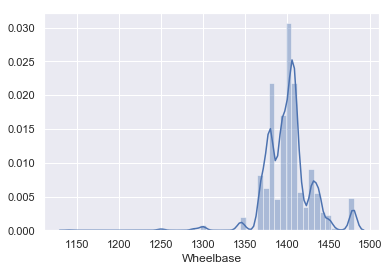

In [44]:
# Check to see if there are still any outliers in the Wheelbase.
sns.distplot(sport['Wheelbase'])


In [45]:
#Manually remove Wheelbase outliers
sport = sport[sport['Wheelbase'] > 1320]



# Remove Colinear features


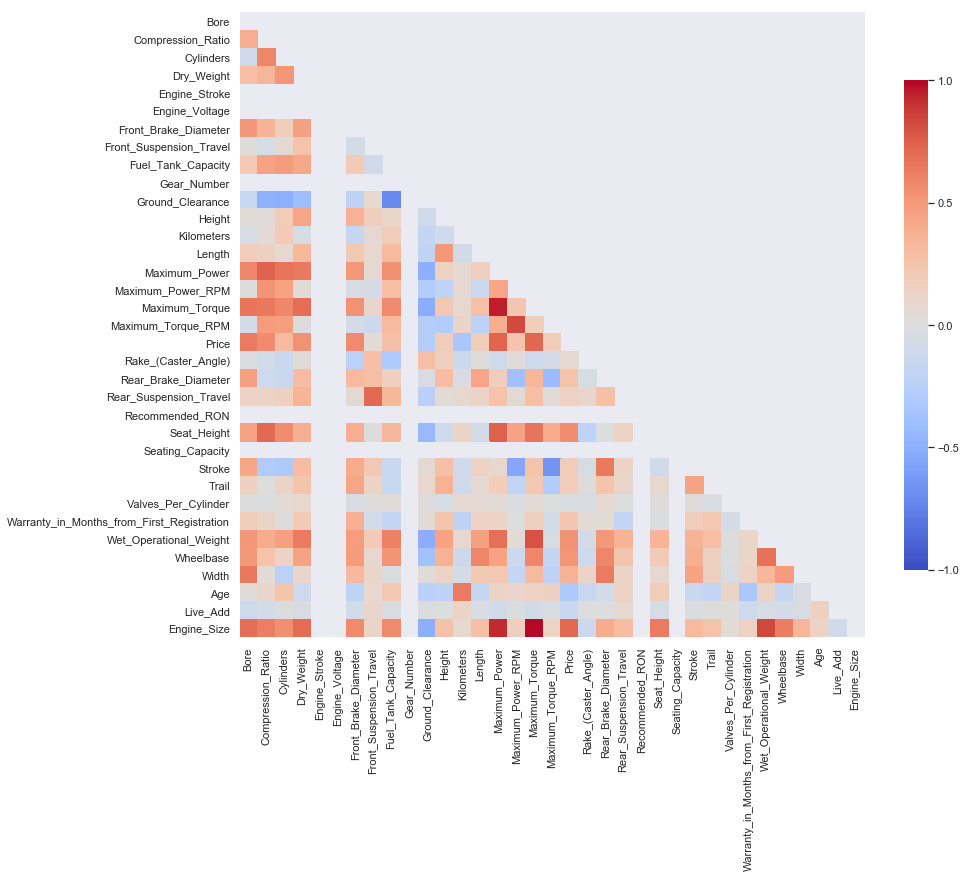

In [46]:
def display_correlation_matrix(df):
    corr_matrix = df.corr()
    mask = np.zeros_like(corr_matrix, dtype=np.bool)
    mask[np.triu_indices_from(mask)]= True

    f, ax = plt.subplots(figsize=(14, 15)) 

    heatmap = sns.heatmap(corr_matrix, mask = mask,square = True,
                          cmap = 'coolwarm', cbar_kws = {'shrink': .6, 'ticks' : [-1, -.5, 0, 0.5, 1]}, 
                          vmin = -1, vmax = 1)

    #add the column names as labels
    ax.set_yticklabels(corr_matrix.columns, rotation = 0)
    ax.set_xticklabels(corr_matrix.columns);


display_correlation_matrix(sport)

In [47]:
def filter_Colinear_Features(df, target, threshold = 0.8):
    drop_list = []

    for col1 in df.select_dtypes(include='number').columns:
        for col2 in df.select_dtypes(include='number').columns:
            if (col1 == col2):
                continue

            correlation = abs(df[col1].corr(df[col2]))

            if correlation > threshold:
                
                col1_corr = abs(df[col1].corr(df[target]))
                col2_corr = abs(df[col2].corr(df[target]))
                        
                if col1_corr > col2_corr:
                    drop_list.append(col2)
                    
                else:
                    drop_list.append(col1)


    return list(set(drop_list))


drop_list = filter_Colinear_Features(sport, 'Price', threshold = 0.8)
drop_list

['Maximum_Torque_RPM',
 'Engine_Size',
 'Maximum_Torque',
 'Wet_Operational_Weight']

In [48]:

#sport.drop(list(set(drop_list)),axis=1,inplace=True)
#sport.columns


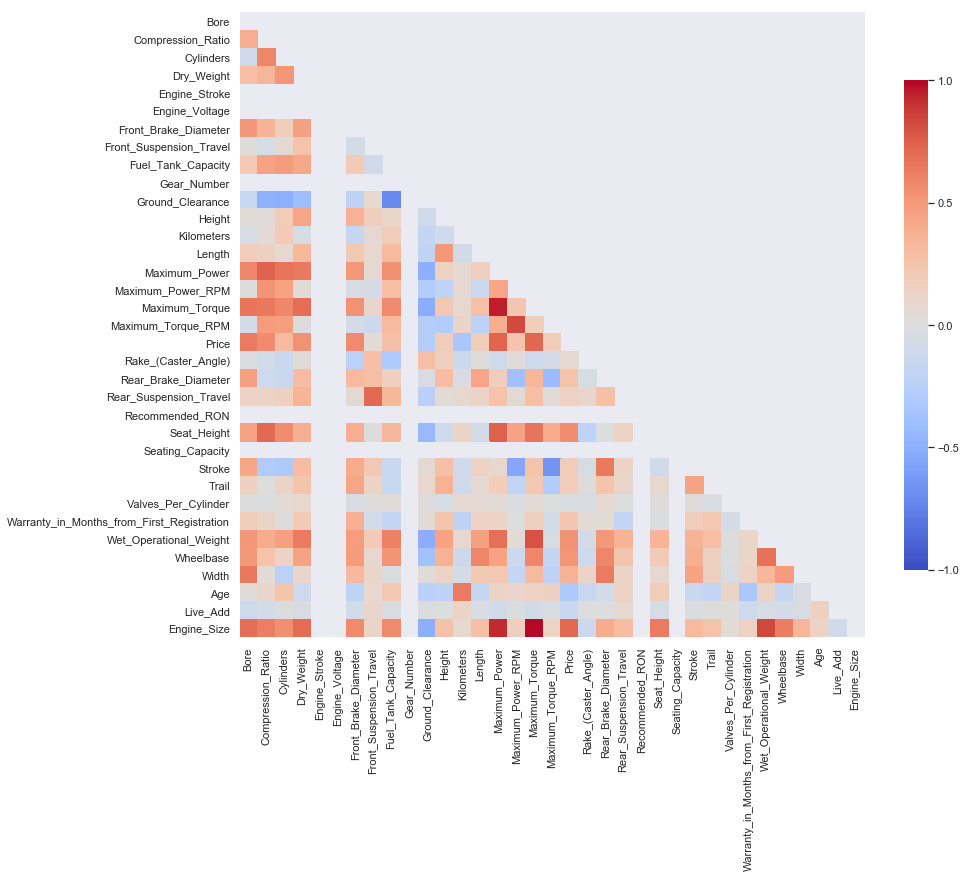

In [49]:
display_correlation_matrix(sport)

In [50]:

sport.columns

Index(['Bore', 'Compression_Ratio', 'Cylinders', 'Dry_Weight', 'Engine_Stroke',
       'Engine_Voltage', 'Front_Brake_Diameter', 'Front_Suspension_Travel',
       'Fuel_Tank_Capacity', 'Gear_Number', 'Ground_Clearance', 'Height',
       'Kilometers', 'Length', 'Maximum_Power', 'Maximum_Power_RPM',
       'Maximum_Torque', 'Maximum_Torque_RPM', 'Price', 'Rake_(Caster_Angle)',
       'Rear_Brake_Diameter', 'Rear_Suspension_Travel', 'Recommended_RON',
       'Seat_Height', 'Seating_Capacity', 'Stroke', 'Trail',
       'Valves_Per_Cylinder', 'Warranty_in_Months_from_First_Registration',
       'Wet_Operational_Weight', 'Wheelbase', 'Width', 'Age', 'Live_Add',
       'Engine_Size', 'ABS', 'Adjustable_Seat', 'Bike', 'Body', 'Cam_Type',
       'Carburettor', 'Charging_Method', 'Clutch_Type', 'Colour', 'Cooling',
       'Country_of_Origin', 'Drive_Type', 'Engine_Config', 'Engine_Type',
       'Exhaust_Config', 'First_Seen', 'Frame_Material',
       'Front_Brake_Caliper(s)', 'Front_Brake_Descri

In [51]:
remove = ['Maximum_Torque', 'Wet_Operational_Weight', 'Maximum_Torque_RPM',
          'Postcode','Suburb','State']

sport.drop(remove, axis=1, inplace=True)    

In [52]:
sport.shape

(2593, 81)

In [53]:

sport.to_csv('clean_sport.csv',index=False)

# Explore the features

In [57]:
def scatter(data,x,y,hue=None,title='',figsize=(12,10)):
    ax = plt.figure(figsize=figsize)
    sns.scatterplot(x=x,y=y,hue=hue,data=data);
    plt.title(title,fontsize=18)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)



def count_plot(data, feature,figsize=(12,10)):
    ax = data[feature].value_counts().sort_values().plot(kind='bar',figsize=figsize);
    ax.set_xlabel(feature);
    ax.set_ylabel('Counts');
    ax.set_title('Distribution of '+feature);
  


In [55]:
@interact
def plot_counts(column=sport.select_dtypes(exclude='number')):
    # remove the description 
    #column = set(list(sport.select_dtypes(exclude='number').columns)) - set(['Description'])
    
    sport[column].value_counts(normalize=True).plot(kind='bar',figsize=(12,10))
    plt.title('Distribution of Bikes',fontsize=16)
    plt.xlabel(column)
    plt.ylabel('Percentage of Bikes')
    
    
# Country - most from Japan
# Engine_Type - could remove, very small variability
# Ignitition - could combine CDI and CD?
# Learner Apprved
# Seller
# Brands


interactive(children=(Dropdown(description='column', options=('ABS', 'Adjustable_Seat', 'Bike', 'Body', 'Cam_T…

In [58]:
@interact
def plot_counts(Feature=sport.select_dtypes(include='number')):
    # remove the description 
    #column = set(list(sport.select_dtypes(exclude='number').columns)) - set(['Description'])
    correlation = sport[Feature].corr(sport['Price'])
    ax = sns.jointplot(Feature,'Price', data=sport, kind='reg')
    plt.gcf().set_size_inches(10,10)
    ax.annotate(stats.pearsonr)
    plt.suptitle('Relationship to Price',x=0.5,y=1.01,size=18)
    plt.xlabel(Feature)

    
# Bore - high correlation
# Fuel_Tank_Capacity - unusual correlation
# Kilometers
# Age
# Engine_Size - consider grouping

interactive(children=(Dropdown(description='Feature', options=('Bore', 'Compression_Ratio', 'Cylinders', 'Dry_…

In [19]:
Remove_outliers = ['Price',
                   'Bore','Compression_Ratio','Fuel_Reserve_Capacity','Length',
                   'Maximum_Power_RPM','Maximum_Torque','Maximum_Torque_RPM','Wheelbase',
                   'Wet_Operational_Weight','Trail','Rear_Susspension_Travel',
                   'Rear_Brake_Diameter']




In [20]:

# No variability in feature
no_variability = ['Adjustable_Seat','Body','Fuel_Type','Engine_Voltage','Gear_Number',
                  'Seating_Capacity','Recommended_RON','Drive_Type','Windscreen','Gear_Type']
no_value = ['URL','Network_ID','Engine_Stroke','Valves_Per_Cylinder','Registration_Plate',
            'Gear_Change_Method','Rake_(Caster_Angle)']

needs_reduction = ['Bike','Model']

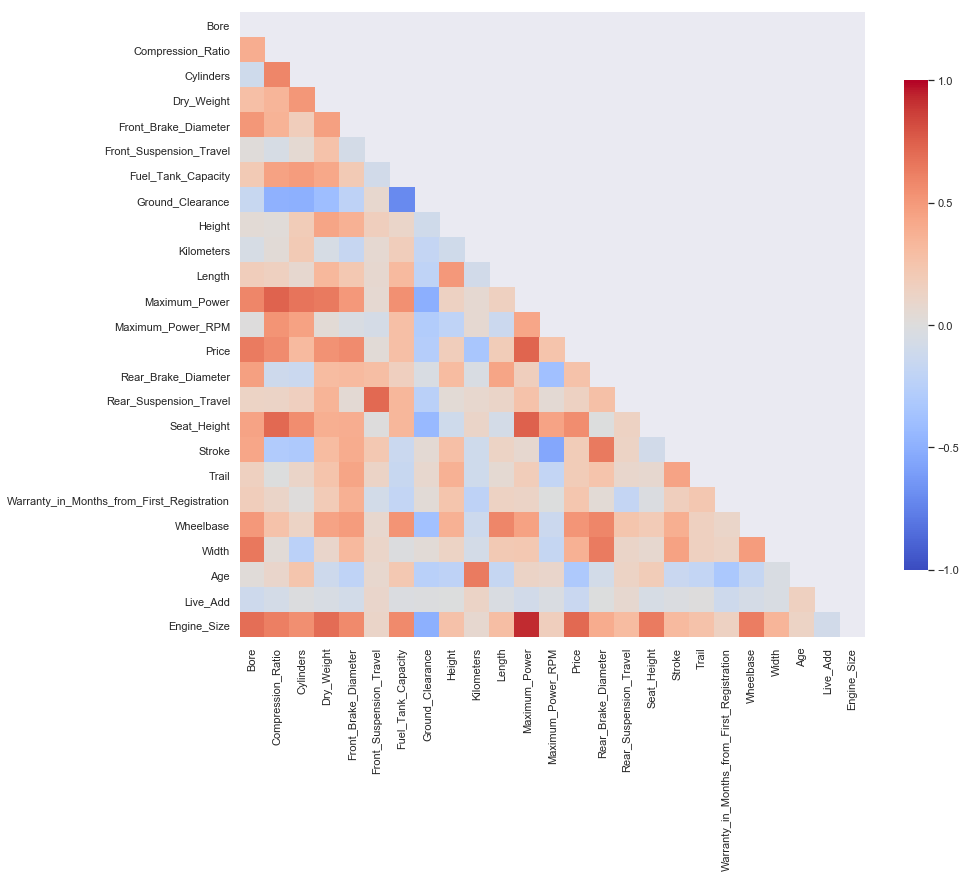

In [21]:

sport.drop(no_variability, axis=1, inplace=True)
sport.drop(no_value, axis=1, inplace=True)

display_correlation_matrix(sport)

In [22]:
sport.to_csv('clean_sport2.csv',index=False)
sport.shape


(2593, 64)

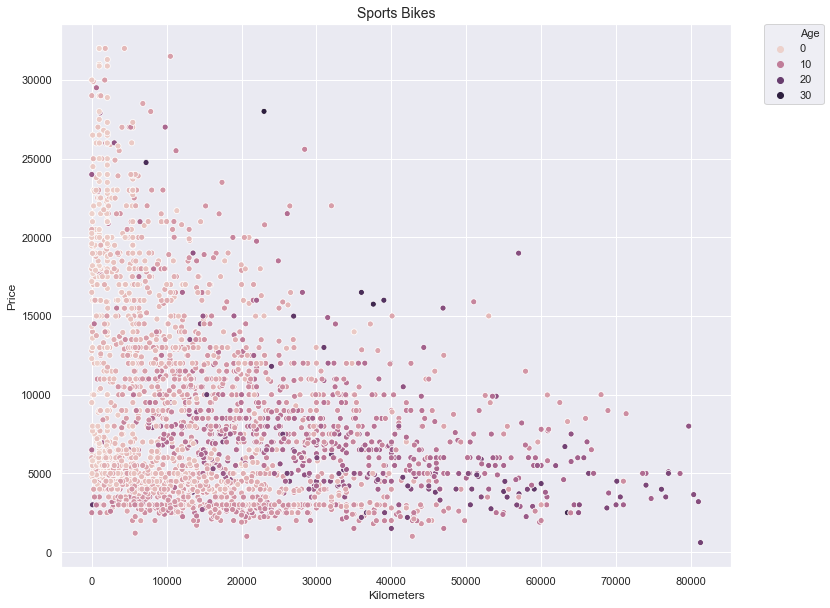

In [50]:
scatter(sport,'Kilometers','Price',hue='Age',title='Sports Bikes')

In [59]:
# Take the top 5 brands
top_5brands = sport['Brand'].value_counts(sort=True).index[:5]
top5 = sport[sport['Brand'].isin(top_5brands) == True].reset_index(drop=True)
top5.head()


,Bore,Compression_Ratio,Cylinders,Dry_Weight,Engine_Stroke,Engine_Voltage,Front_Brake_Diameter,Front_Suspension_Travel,Fuel_Tank_Capacity,Gear_Number,...,Swingarm_Type,Traction_Control,URL,Warranty_KMs,Wheel_Type,Windscreen,Seller,Brand,Model,Sold
0,74.0,11.0,4.0,170.0,4.0,12.0,290.235019,157.464301,18.0,6.0,...,Dual Sided,No,https://www.bikesales.com.au/bikes/details/200...,No,Spoke,Standard,Private,Honda,Cbr900rr fireblade 929,Sold
1,62.0,11.0,2.0,152.0,4.0,12.0,290.000000,120.000000,18.0,6.0,...,Dual Sided,No,https://www.bikesales.com.au/bikes/details/200...,No,Spoke,Standard,Private,Kawasaki,Ninja 250r ex250j,Sold
2,62.0,11.0,2.0,130.0,4.0,12.0,290.000000,120.000000,18.0,6.0,...,Dual Sided,No,https://www.bikesales.com.au/bikes/details/201...,No,Spoke,Standard,Private,Kawasaki,Ninja 250r special edition,Sold
3,62.0,11.0,2.0,152.0,4.0,12.0,290.000000,120.000000,18.0,6.0,...,Dual Sided,No,https://www.bikesales.com.au/bikes/details/200...,No,Spoke,Standard,Private,Kawasaki,Ninja 250r ex250j,Sold
4,62.0,11.0,2.0,152.0,4.0,12.0,290.000000,120.000000,18.0,6.0,...,Dual Sided,No,https://www.bikesales.com.au/bikes/details/201...,No,Spoke,Standard,Dealer,Kawasaki,Ninja 250r ex250j,Sold


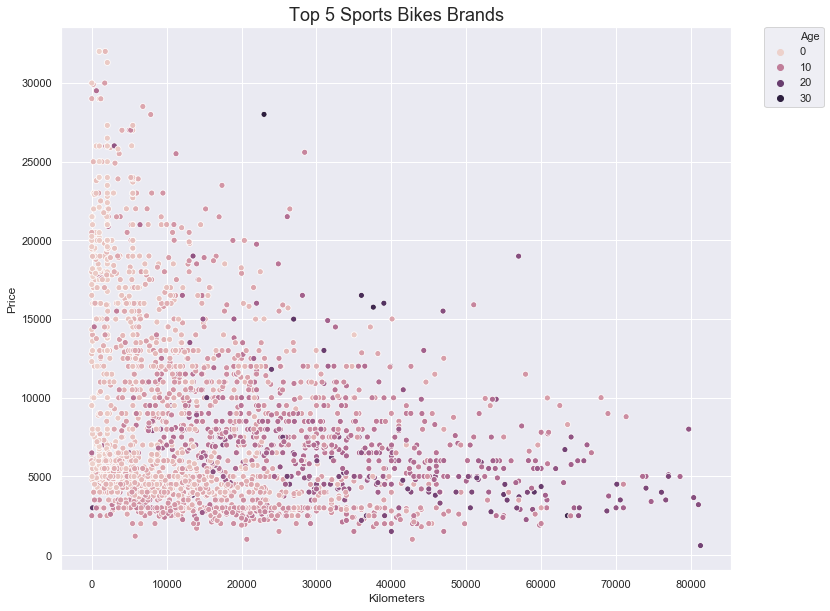

In [64]:
scatter(top5,'Kilometers','Price',hue='Age',title='Top 5 Sports Bikes Brands')

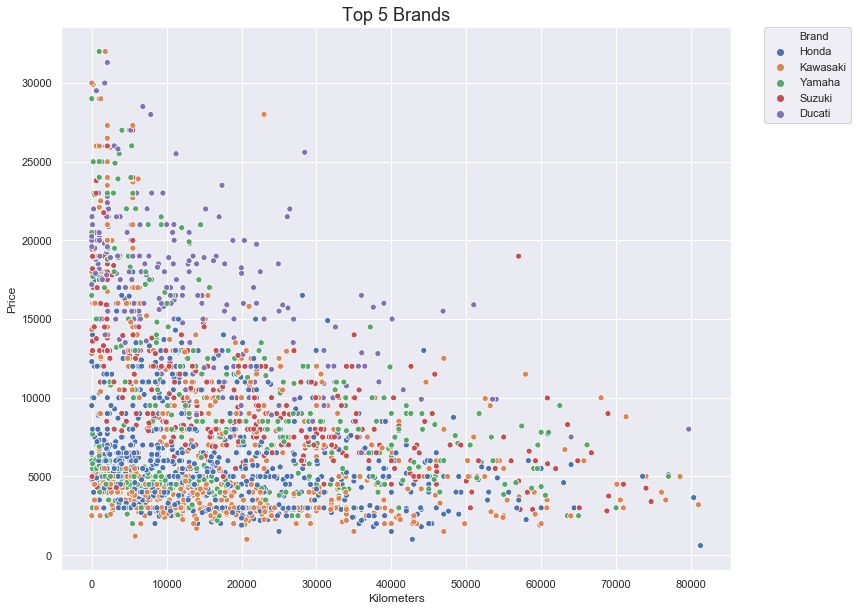

In [65]:

scatter(top5,'Kilometers','Price',hue='Brand',title='Top 5 Brands')

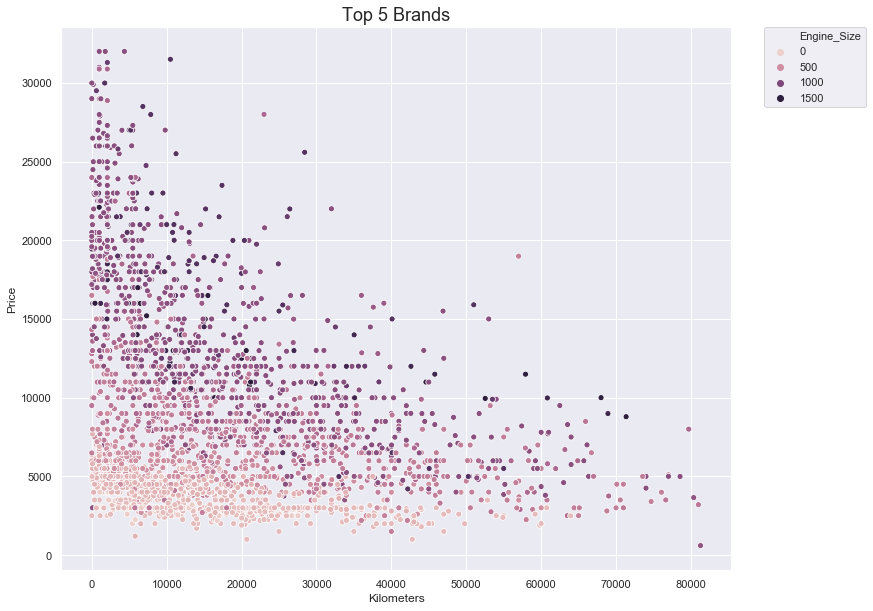

In [66]:

scatter(sport,'Kilometers','Price',hue='Engine_Size',title='Top 5 Brands')

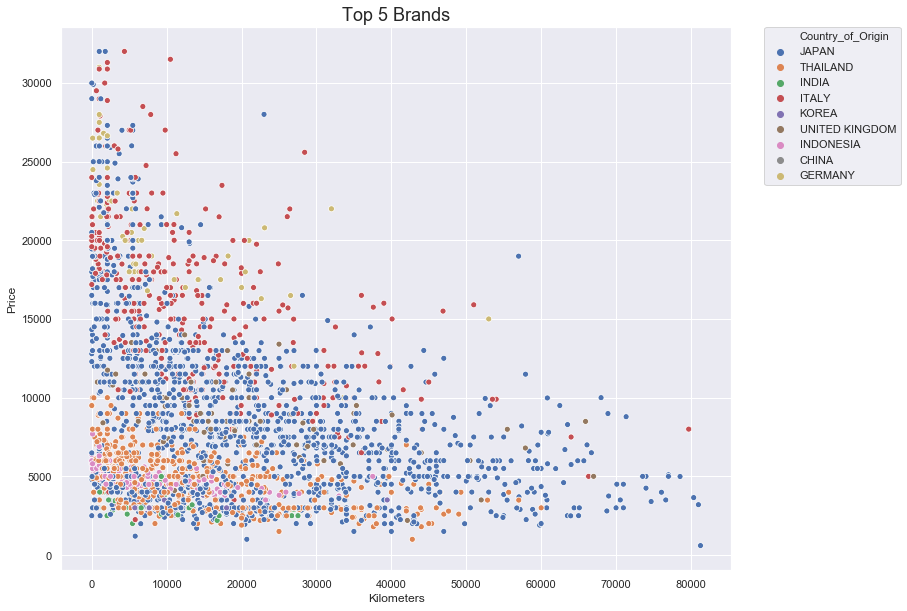

In [67]:
scatter(sport,'Kilometers','Price',hue='Country_of_Origin',title='Top 5 Brands')

In [54]:

@interact
def plot_scatter(Feature=sport.columns,Hue=sport.columns):
    hue_list = sorted(list(sport[Hue].unique()))
    correlation = sport[Feature].corr(sport['Price'])
    #ax = plt.figure(figsize=(12,10))
    sns.lmplot(x=Feature, y='Price', hue=Hue, data=sport, fit_reg=False, 
               height=10,aspect=1.2,scatter_kws={'alpha':0.5})
    for idx, h in enumerate(hue_list):
        subset = sport[sport[Hue] == h]
        correlation = subset[Feature].corr(subset['Price'])
        ypos = 0.95 - idx*0.025
        plt.gca().annotate(f'{h}:',xy=(0.87, ypos), xycoords='figure fraction', fontsize=14)
        plt.gca().annotate(f'{correlation:.3f}',xy=(0.95, ypos), xycoords='figure fraction', fontsize=14)

    plt.title('Relationship to Price',fontsize=18)
    plt.xlabel(Feature);



interactive(children=(Dropdown(description='Feature', options=('Bore', 'Compression_Ratio', 'Cylinders', 'Dry_…

In [55]:
@interact
def plot_scatter(Feature=top5.columns,Hue=top5.columns):
    hue_list = sorted(list(top5[Hue].unique()))
    correlation = top5[Feature].corr(top5['Price'])
    sns.lmplot(x=Feature, y='Price', hue=Hue, data=top5, fit_reg=False, 
               height=10,aspect=1.2,scatter_kws={'alpha':0.5})
    for idx, h in enumerate(hue_list):
        subset = top5[top5[Hue] == h]
        correlation = subset[Feature].corr(subset['Price'])
        ypos = 0.95 - idx*0.025
        plt.gca().annotate(f'{h}:',xy=(0.87, ypos), xycoords='figure fraction', fontsize=14)
        plt.gca().annotate(f'{correlation:.3f}',xy=(0.95, ypos), xycoords='figure fraction', fontsize=14)

    plt.title('Top 5 Brands',fontsize=18)
    plt.xlabel(Feature);



interactive(children=(Dropdown(description='Feature', options=('Bore', 'Compression_Ratio', 'Cylinders', 'Dry_…

In [56]:
top5.head()

,Bore,Compression_Ratio,Cylinders,Dry_Weight,Front_Brake_Diameter,Front_Suspension_Travel,Fuel_Tank_Capacity,Ground_Clearance,Height,Kilometers,...,Side_Stand,Starter,Swingarm_Type,Traction_Control,Warranty_KMs,Wheel_Type,Seller,Brand,Model,Sold
0,74.0,11.0,4.0,170.0,290.235019,157.464301,18.0,138.0,1125.0,81276.0,...,Yes,Electric,Dual Sided,No,No,Spoke,Private,Honda,Cbr900rr fireblade 929,Sold
1,62.0,11.0,2.0,152.0,290.000000,120.000000,18.0,130.0,1110.0,47000.0,...,Standard,Electric,Dual Sided,No,No,Spoke,Private,Kawasaki,Ninja 250r ex250j,Sold
2,62.0,11.0,2.0,130.0,290.000000,120.000000,18.0,135.0,1110.0,14000.0,...,Standard,Electric,Dual Sided,No,No,Spoke,Private,Kawasaki,Ninja 250r special edition,Sold
3,62.0,11.0,2.0,152.0,290.000000,120.000000,18.0,130.0,1110.0,59800.0,...,Standard,Electric,Dual Sided,No,No,Spoke,Private,Kawasaki,Ninja 250r ex250j,Sold
4,62.0,11.0,2.0,152.0,290.000000,120.000000,18.0,130.0,1110.0,49782.0,...,Standard,Electric,Dual Sided,No,No,Spoke,Dealer,Kawasaki,Ninja 250r ex250j,Sold


In [168]:
top5.shape

(2337, 62)

In [27]:
@interact
def correlations(column1=sport.select_dtypes(include='number'),
                column2=sport.select_dtypes(include='number')):
    print(sport[column1].corr(sport[column2]))


interactive(children=(Dropdown(description='column1', options=('Bore', 'Carburettor(s)', 'Compression_Ratio', …

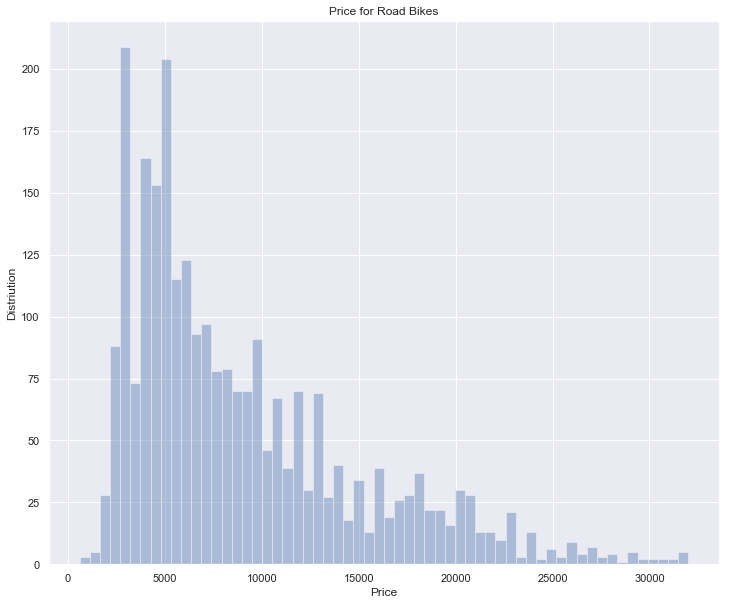

In [34]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.distplot(sport['Price'],bins=60,kde=False,label='Price')
plt.title('Price for Road Bikes')
plt.ylabel('Distriution');


In [27]:
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    n = len(data)
    mean, sem = np.mean(data), scipy.stats.sem(data)
    interval = sem * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return mean, interval


In [28]:
mean_confidence_interval(sport['Price'], confidence=0.95)

(8987.96529116853, 230.74141545754057)

In [32]:
sport['Price'].mean()

8987.96529116853